In [215]:
%pylab inline
from matplotlib import pyplot as plt
import seaborn
import pandas as pd
from yahoo_finance import Share
import datetime
from datetime import datetime
import numpy as np
import itertools
import os

import get_spread as gs
from sklearn.linear_model import LinearRegression

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [216]:
def get_dailyret(ser):
    return (ser.shift(-1) - ser)/ser

In [217]:
def get_dailyret_spread(ser):
    return (ser.shift(-1) - ser)

In [218]:
# just a function to gather price data
def get_ticker_data(strat, fin_data_path = '../data/pricedata'):
    ''' this should have parameters
        date range
        type of smooth val (which function)
    '''
    start = '2012-01-15'
    end = '2016-03-03'
    path = ''.join((fin_data_path, strat, '_', start, end))
    if os.path.exists(path):
        data = pd.read_pickle(path)
        print('found data')
    else:
        data = pd.DataFrame(Share(strat).get_historical(start, end))
        print('fetched data')
        data.Date = [datetime.strptime(data.Date.iloc[i], '%Y-%m-%d') for i in data.index]
        data.index = data.Date
        data = data.iloc[::-1]
        data.Close = [float(x) for x in data.Adj_Close]
        data.to_pickle(path)
    return data

# import data

In [219]:
pricedata = pd.DataFrame()
returndata = pd.DataFrame()
for symbol in ['GS','XLF']:
    try:
        data = pd.read_pickle('../data/pricedata/'+symbol+'_2010-05-022015-12-31')
        
    except:
        data = get_ticker_data(symbol)
    pricedata[symbol] = data.Close
    returndata[symbol] = get_dailyret(data.Close)

found data
found data


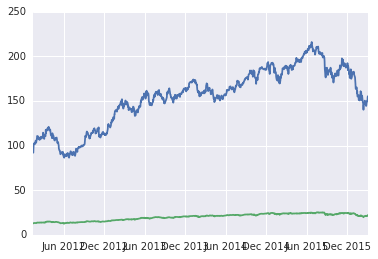

In [220]:
plot(pricedata)

# regress data

In [221]:
LM =LinearRegression(fit_intercept=True)       #intercept is set to zero
LM.fit(pricedata.GS.reshape(pricedata.shape[0], 1), pricedata.XLF)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [222]:
intercept = LM.intercept_
slope = LM.coef_

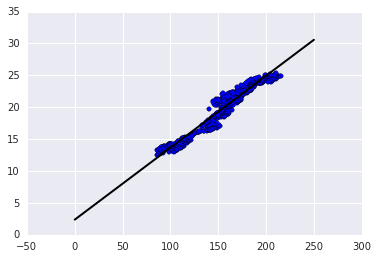

In [223]:
plt.scatter(pricedata.GS, pricedata.XLF)
plt.plot([0, 250], [intercept,250*slope+intercept ],  'k-', lw=2)

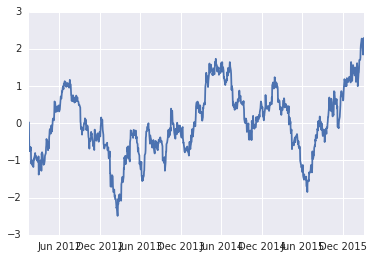

In [224]:
#plot residuals
spreadprice = pricedata.XLF - pricedata.GS*slope-intercept
plt.plot(spreadprice)

plot(pricedata.GS*slope)
plot(pricedata.XLF)
show()
spreadprice= pricedata.GS*slope - pricedata.XLF
plot(spreadprice)
show()
spreadret = get_dailyret_spread(spreadprice)/(pricedata.GS*slope+pricedata.XLF)
plot(spreadret)

plot(pricedata.GS)
plot(pricedata.XLF/slope)
show()
spreadprice= pricedata.GS - pricedata.XLF/slope
plot(spreadprice)
show()
spreadret = get_dailyret_spread(spreadprice)/(pricedata.GS+pricedata.XLF/slope)

plot(spreadret)

# kalman filter

In [225]:
import filterpy as fp
from filterpy.kalman import predict, update
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import KalmanFilter


def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) #init location and velocity
    kf.F = np.array([[1, dt],
                     [0,  1]])    # state transition matrix
    kf.H = np.array([[1, 0]])     # Measurement function
    kf.R *= R                   # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q = Q
    return kf



def run(x0=(200.,0.), P=500, R=1, Q=0, dt=1.0, data=None,
        count=0, do_plot=True, **kwargs):
    """
    `data` is a 2D numpy array; the first column contains
    the actual position, the second contains the measurements
    """

    # create the Kalman filter
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)  

    # run the kalman filter and store the results
    xs, cov = [], []
    for n in range(data.shape[0]):
        row = data.iloc[n]
        z = row['Close']
        
        kf.predict( )
        
        
        R = row.rol_std*1         #(float(row['High'])-float(row['Low']))*2
        kf.update(z, R =R)
        
        xs.append(kf.x)
        cov.append(kf.P)
        
        
    xs, cov = np.array(xs), np.array(cov)
    
    return xs, cov


In [226]:
#format data
data = pd.DataFrame(spreadprice)
data.columns = ['price']
data['rol_std'] =  pd.rolling_std(data['price'], 100)
data['Close'] = data.price
data['dailyrets'] = get_dailyret_spread(spreadprice)/(pricedata.XLF+pricedata.GS*slope)

In [227]:
#run kalman flter
data = data.dropna()
xs , cov = run(P=200, Q=.000005,R=500, data=data)
data['kal_mean'], data['kal_vel'], data['kal_pricecov'], data['kal_velcov'] = xs[:,0], xs[:,1], cov[:,0][:,0], cov[:,1][:,1]


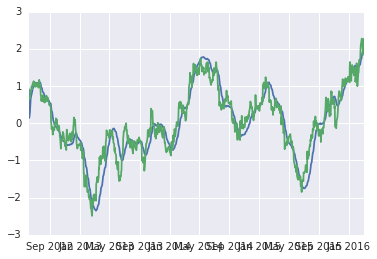

In [228]:
#plot filtered data with actual price
plot(data.kal_mean)
plot(data.price)

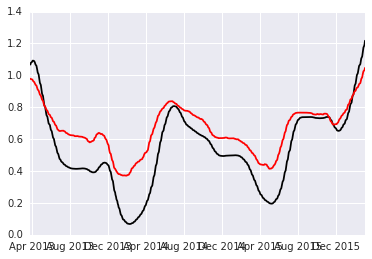

In [229]:
plot(pd.rolling_std(data.kal_mean, 200)**2, 'black')
plot(pd.rolling_std(data.price, 200), 'r')

In [230]:
# the prediction's formula is p = m + v(dt)
data['kal_predict']  = data.kal_mean# + data.kal_vel
# a residual between what tomorrow's predicted value is and today's price
data['kal_res'] = data.kal_predict - data.Close
# a rolling standard deviation of the residual to use as part of the threshold
#data['rol_std'] = pd.rolling_std(data.kal_res, 100)
# The logic for the trade. Note how some coefficients are zero. I dont really know how they all fit together yet
data['kal_threshold'] = data.kal_pricecov*pd.rolling_std(data.price, 200)**2        #need to set this intelligently
data['kal_returns'] = (
    abs(data.kal_res) > data.kal_threshold
                      ) * sign(data.kal_res)*data.dailyrets
# a cumulative product to get the equity curve
data['kal_eq_curve'] = np.cumprod(data.kal_returns+1)

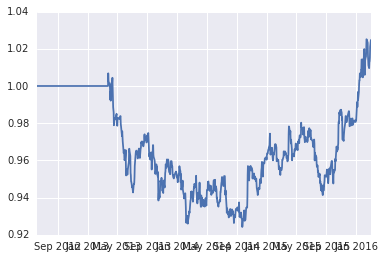

In [231]:
plt.plot(data.kal_eq_curve)

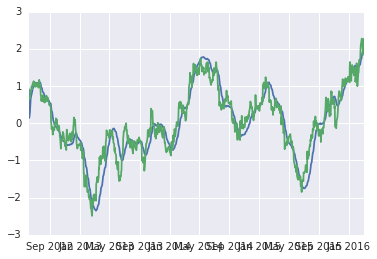

In [232]:
plot(data.kal_mean)
plot(data.price)

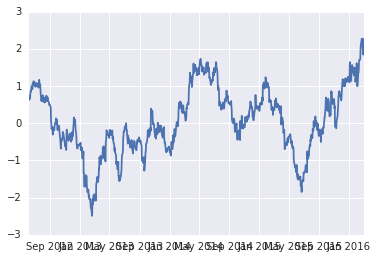

In [233]:
plot(data.price)

In [234]:
resid=data.kal_mean-data.price


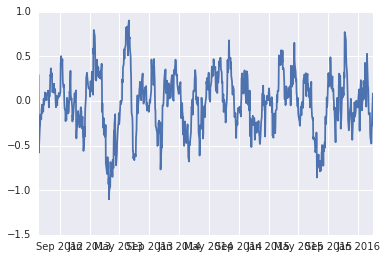

In [235]:
plot(resid)

In [236]:
cov[:1]

array([[[   0.58361172,    0.29180586],
        [   0.29180586,  100.14590575]]])

In [237]:
cov[1:]

array([[[  5.91291423e-01,   5.86182251e-01],
        [  5.86182251e-01,   1.15716599e+00]],

       [[  5.01721475e-01,   2.99462328e-01],
        [  2.99462328e-01,   2.95357797e-01]],

       [[  4.27900794e-01,   1.82323875e-01],
        [  1.82323875e-01,   1.19601566e-01]],

       ..., 
       [[  4.00294463e-02,   1.57124187e-03],
        [  1.57124187e-03,   1.25266021e-04]],

       [[  4.02677623e-02,   1.58008547e-03],
        [  1.58008547e-03,   1.25599569e-04]],

       [[  4.05321148e-02,   1.58963833e-03],
        [  1.58963833e-03,   1.25950258e-04]]])

In [238]:
cov[:1]

array([[[   0.58361172,    0.29180586],
        [   0.29180586,  100.14590575]]])

In [239]:
cov[:100][1,1]

array([ 0.58618225,  1.15716599])

In [240]:
cov[1][1]

array([ 0.58618225,  1.15716599])

cov[1][1]

In [241]:
a=cov[:,0][:,0]**.5

In [242]:
b=abs(xs[:,1])

In [243]:
c=b-a

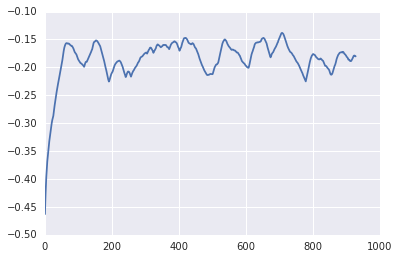

In [244]:
plot(c[10:])

In [245]:
slope

array([ 0.11280587])

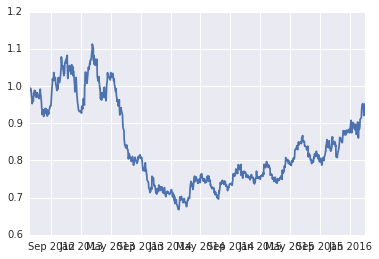

In [246]:
plot(np.cumprod(3*data.dailyrets*sign(data.kal_vel)+1))

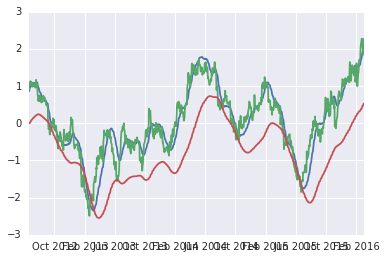

In [247]:
plot(data.kal_mean[9:])
plot(data.price[9:])
plot(cumsum(data.kal_vel[9:]))

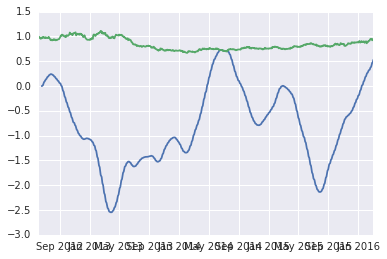

In [248]:
plot(cumsum(data.kal_vel[9:]))
plot(np.cumprod(3*data.dailyrets*sign(data.kal_vel)+1))

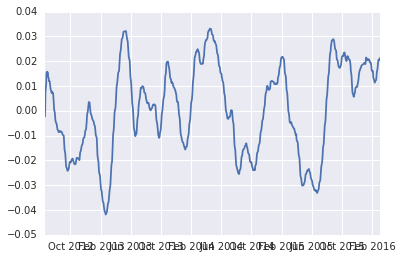

In [249]:
plot(data.kal_vel[9:])

In [250]:
intercept

2.3787071319604394

In [251]:
slope

array([ 0.11280587])

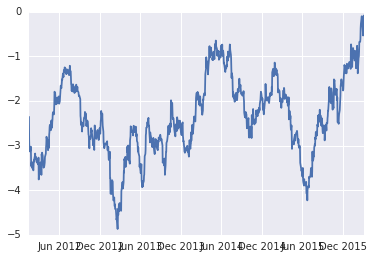

In [252]:
plot(spreadprice-intercept)

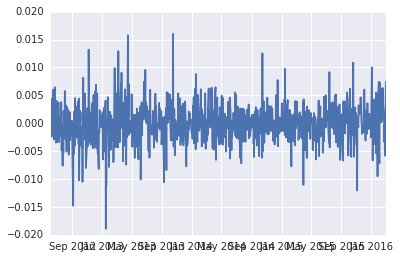

In [253]:
plot(data.dailyrets)

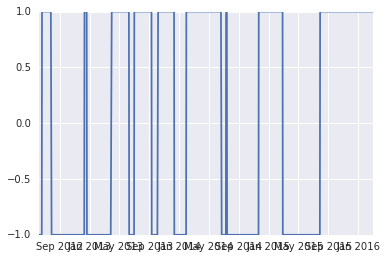

In [254]:
plot(1*sign(data.kal_vel))

In [255]:
slope

array([ 0.11280587])

In [256]:
a=data.kal_mean.shift(-1)-data.kal_mean

In [257]:
a


Date
2012-06-07   -0.769652
2012-06-08    0.154417
2012-06-11    0.127434
2012-06-12    0.126744
2012-06-13    0.094429
2012-06-14    0.053709
2012-06-15    0.093087
2012-06-18    0.038251
2012-06-19    0.030122
2012-06-20    0.016721
2012-06-21    0.055346
2012-06-22    0.035781
2012-06-25    0.048786
2012-06-26    0.019829
2012-06-27    0.008404
2012-06-28    0.025907
2012-06-29    0.010991
2012-07-02   -0.006477
2012-07-03    0.008525
2012-07-05   -0.003964
2012-07-06    0.010717
2012-07-09   -0.003409
2012-07-10   -0.000393
2012-07-11   -0.003732
2012-07-12   -0.001982
2012-07-13   -0.009361
2012-07-16   -0.002817
2012-07-17    0.009020
2012-07-18    0.017456
2012-07-19    0.001513
                ...   
2016-01-20    0.019130
2016-01-21    0.003122
2016-01-22    0.017534
2016-01-25    0.014445
2016-01-26    0.013320
2016-01-27   -0.014838
2016-01-28   -0.008998
2016-01-29   -0.000182
2016-02-01    0.021213
2016-02-02    0.012944
2016-02-03   -0.007387
2016-02-04   -0.029641
2016-0

In [258]:
data.kal_mean[:9]

Date
2012-06-07    0.908825
2012-06-08    0.139173
2012-06-11    0.293590
2012-06-12    0.421024
2012-06-13    0.547768
2012-06-14    0.642196
2012-06-15    0.695906
2012-06-18    0.788993
2012-06-19    0.827244
Name: kal_mean, dtype: float64

In [259]:
data.kal_mean.shift(-1)[:9]

Date
2012-06-07    0.139173
2012-06-08    0.293590
2012-06-11    0.421024
2012-06-12    0.547768
2012-06-13    0.642196
2012-06-14    0.695906
2012-06-15    0.788993
2012-06-18    0.827244
2012-06-19    0.857366
Name: kal_mean, dtype: float64

In [260]:
data.kal_mean.shift(-1)[:9]-data.kal_mean[:9]

Date
2012-06-07   -0.769652
2012-06-08    0.154417
2012-06-11    0.127434
2012-06-12    0.126744
2012-06-13    0.094429
2012-06-14    0.053709
2012-06-15    0.093087
2012-06-18    0.038251
2012-06-19    0.030122
Name: kal_mean, dtype: float64

In [261]:
a[:9]

Date
2012-06-07   -0.769652
2012-06-08    0.154417
2012-06-11    0.127434
2012-06-12    0.126744
2012-06-13    0.094429
2012-06-14    0.053709
2012-06-15    0.093087
2012-06-18    0.038251
2012-06-19    0.030122
Name: kal_mean, dtype: float64

In [262]:
b=data.kal_mean.shift(-1)-data.kal_mean

In [263]:
b[:9]

Date
2012-06-07   -0.769652
2012-06-08    0.154417
2012-06-11    0.127434
2012-06-12    0.126744
2012-06-13    0.094429
2012-06-14    0.053709
2012-06-15    0.093087
2012-06-18    0.038251
2012-06-19    0.030122
Name: kal_mean, dtype: float64

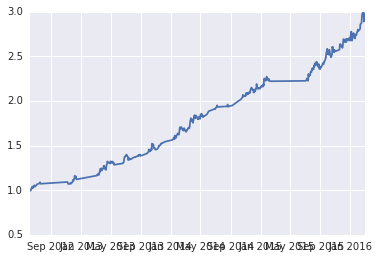

In [264]:
plot(np.cumprod(3*data.dailyrets[b>0]+1))

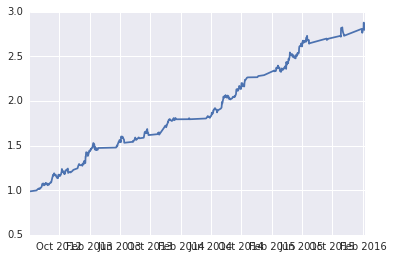

In [265]:
plot(np.cumprod(-3*data.dailyrets[b<0]+1))

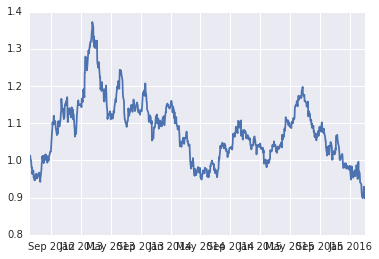

In [266]:
plot(np.cumprod(3*data.dailyrets*sign(c)+1))

In [267]:
c=data.kal_mean-data.kal_mean.shift(1)

In [268]:
b[:9]

Date
2012-06-07   -0.769652
2012-06-08    0.154417
2012-06-11    0.127434
2012-06-12    0.126744
2012-06-13    0.094429
2012-06-14    0.053709
2012-06-15    0.093087
2012-06-18    0.038251
2012-06-19    0.030122
Name: kal_mean, dtype: float64

In [269]:
c[:9]

Date
2012-06-07         NaN
2012-06-08   -0.769652
2012-06-11    0.154417
2012-06-12    0.127434
2012-06-13    0.126744
2012-06-14    0.094429
2012-06-15    0.053709
2012-06-18    0.093087
2012-06-19    0.038251
Name: kal_mean, dtype: float64

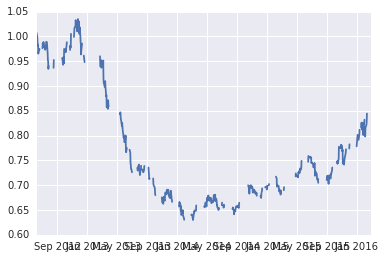

In [270]:
plot(np.cumprod(3*data.dailyrets[sign(data.kal_vel)==sign(data.kal_mean-data.Close)]*sign(data.kal_vel)+1))

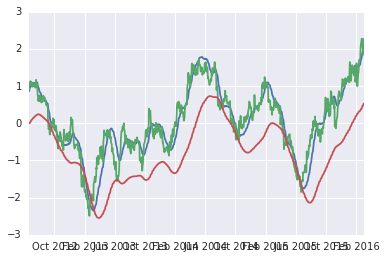

In [271]:
plot(data.kal_mean[9:])
plot(data.price[9:])
plot(cumsum(data.kal_vel[9:]))

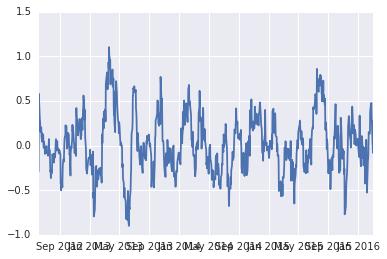

In [272]:
plot(data.price-data.kal_mean)

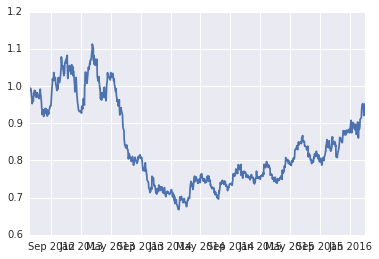

In [273]:
plot(np.cumprod(3*data.dailyrets*sign(data.kal_vel)+1))

In [274]:
d=data.kal_mean+data.kal_vel


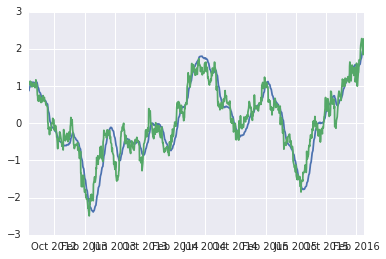

In [275]:
plot(d[10:])
plot(data.Close[11:])

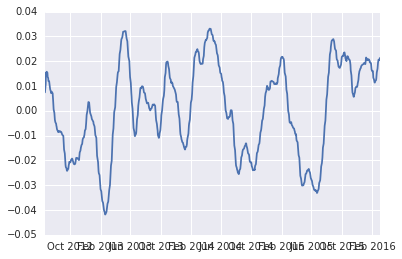

In [276]:
plot(d[10:]-data.kal_mean[11:])


In [277]:
e=data.price-data.kal_mean

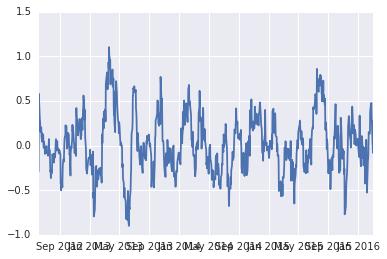

In [278]:
plot(data.price-data.kal_mean)

In [279]:
def movingaverage(interval, window_size):
    window= numpy.ones(int(window_size))/float(window_size)
    return numpy.convolve(interval, window, 'same')


In [280]:
f=movingaverage(data.price-data.kal_mean,6)

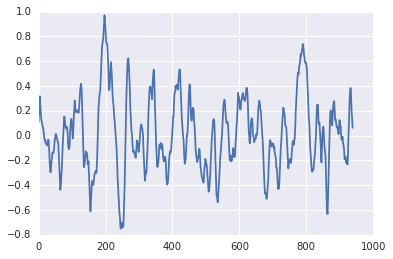

In [281]:
plot(f)

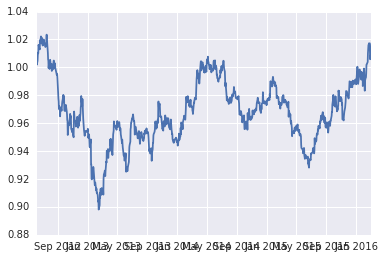

In [282]:
plot(cumprod(1+data.dailyrets))

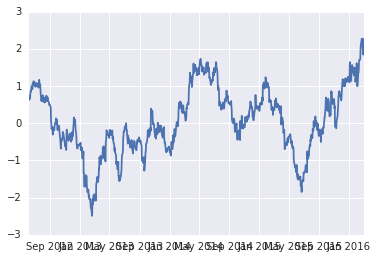

In [283]:
plot(data.Close)